In [2]:
import json

# Read data from the JSON file as text, specifying the encoding
with open('TrainingDataSet.json', 'r', encoding='utf-8') as file:
    json_text = file.read()

# Parse the JSON text
data = json.loads(json_text)

# Extract the 'annotations' from the JSON data
annotations = data['annotation']

# Define TRAIN_DATA as an empty list
TRAIN_DATA = []

# Iterate over each annotation and append it to TRAIN_DATA
for annotation in annotations:
    TRAIN_DATA.append(annotation)

# Print TRAIN_DATA to verify
print(TRAIN_DATA)
print(len(TRAIN_DATA))


[['VAT: GB123 4567 89', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB123 4567 89', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB234 5678 90', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB234 5678 90', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB345 6789 01', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB345 6789 01', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB456 7890 12', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB456 7890 12', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB567 8901 23', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB567 8901 23', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB678 9012 34', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB678 9012 34', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB789 0123 45', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB789 0123 45', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB890 1234 56', {'entities': [[5, 18, 'VAT']]}], ['VAT Number: GB890 1234 56', {'entities': [[12, 25, 'VAT']]}], ['VAT: GB901 2345 67', {'entities': [[5

In [17]:
import os
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import spacy
from spacy.tokens import DocBin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [4]:
# Extracting text and annotations separately
texts = [text for text, _ in TRAIN_DATA]
annotations = [annot for _, annot in TRAIN_DATA]

In [5]:
# Splitting the data into training and testing sets
train_texts, test_texts, train_annotations, test_annotations = train_test_split(texts, annotations, test_size=0.3, random_state=42)
print(len(train_texts))
print(len(test_texts))

477
205


In [6]:
# Combining the text and annotations into training and testing data
train_data = list(zip(train_texts, train_annotations))
test_data = list(zip(test_texts, test_annotations))

In [10]:
nlp = spacy.blank("en")

In [11]:
# Creating a DocBin object for training data
train_doc_bin = DocBin()
for text, annot in train_data:
    doc = nlp.make_doc(text)
    entities = []
    for start, end, label in annot.get("entities", []):
        span = doc.char_span(start, end, label=label)
        if span is None:
            continue
        entities.append(span)
    doc.ents = entities
    train_doc_bin.add(doc)

In [12]:
# Creating a DocBin object for testing data
test_doc_bin = DocBin()
for text, annot in test_data:
    doc = nlp.make_doc(text)
    entities = []
    for start, end, label in annot.get("entities", []):
        span = doc.char_span(start, end, label=label)
        if span is None:
            continue
        entities.append(span)
    doc.ents = entities
    test_doc_bin.add(doc)

In [13]:
# Saving the DocBin objects to disk
train_doc_bin.to_disk("./train.spacy")
test_doc_bin.to_disk("./test.spacy")

In [14]:
# Loading the trained model
nlp_trained = spacy.load("./output/model-best")

In [25]:
def evaluate_model(nlp, test_data):
    # Initialize lists to store true and predicted labels
    true_labels = []
    pred_labels = []

    # Initialize variables to track true positives, false positives, and false negatives
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_tokens = 0

    # Iterate over the test data
    for text, annot in test_data:
        # Process the text with the trained model
        doc = nlp(text)
        # Extract the true labels
        true_entities = set((start, end, label) for start, end, label in annot.get("entities", []))
        # Extract the predicted labels
        pred_entities = set((ent.start_char, ent.end_char, ent.label_) for ent in doc.ents)
        # Calculate true positives
        true_positives += len(true_entities.intersection(pred_entities)) #True positives are entities that are correctly identified by the model.
        # Calculate false positives
        false_positives += len(pred_entities - true_entities) #False positives are entities that are identified by the model but are not present in the true labels.
        # Calculate false negatives
        false_negatives += len(true_entities - pred_entities) #False negatives are entities that are present in the true labels but are not identified by the model.
        
        # Count total tokens in the text
        total_tokens += len(doc)

        # Add true and predicted labels to the respective lists
        true_labels.extend(true_entities)
        pred_labels.extend(pred_entities)

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives + 1e-9)  # Adding a small value to avoid division by zero
    recall = true_positives / (true_positives + false_negatives + 1e-9)  # Adding a small value to avoid division by zero
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)  # Adding a small value to avoid division by zero

    # Calculate accuracy
    accuracy = (true_positives + total_tokens - len(true_labels)) / total_tokens

    # Generate confusion matrix
    confusion_mat = [[true_positives, false_negatives], [false_positives, None]]

    return accuracy, precision, recall, f1, confusion_mat


In [26]:
# Evaluate the model on the testing data
accuracy, precision, recall, f1, confusion_mat = evaluate_model(nlp_trained, test_data)

In [27]:
# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.987012987012987
Precision: 0.9796954314671082
Recall: 0.9234449760721367
F1 Score: 0.9507389157519109
Confusion Matrix:
[[193, 16], [4, None]]


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Visualize evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]


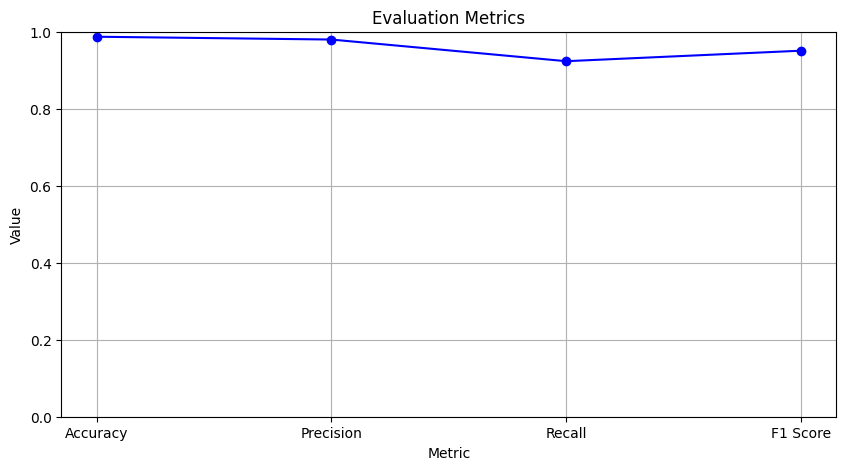

In [32]:
# Visualize evaluation metrics with a line plot
plt.figure(figsize=(10, 5))
plt.plot(metrics, values, marker='o', linestyle='-', color='blue')
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.ylim(0, 1)  # Limit y-axis to range [0, 1]
plt.grid(True)  # Add grid lines
plt.show()

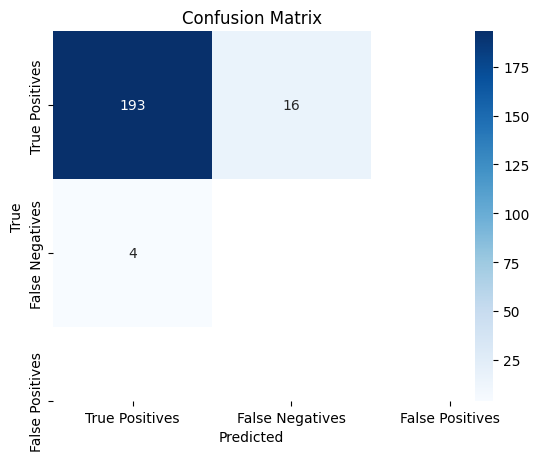

In [34]:

# Convert confusion matrix to numpy array with numeric values
confusion_mat = np.array(confusion_mat, dtype=float)

# Visualize confusion matrix
labels = ['True Positives', 'False Negatives', 'False Positives']
sns.heatmap(confusion_mat, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [37]:
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path):
    text = ""
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text()
            text += "\n\n"  # Add two new lines after each page
    return text

# Define paths for Tax Invoice and Payslip PDF files
tax_invoice_path = "Test Files\\Tax Invoice.pdf"
pay_slip_path = "Test Files\\PaySlip.pdf"


doc_type = input("Enter the document type (Tax Invoice/PaySlip): ").strip().title().upper()


if doc_type == "TAX INVOICE":
    pdf_file_path = tax_invoice_path
elif doc_type == "PAYSLIP":
    pdf_file_path = pay_slip_path
else:
    print("")

# Extract text from the selected PDF file
invoice_text = extract_text_from_pdf(pdf_file_path)

# Print the extracted text
print(invoice_text)


Tax Invoice 
 
Invoice Number: 22/2001 
Tax Code: 1456G 
Date: 17 April 2024 
 
To: 
Siya Philip 
71 Meadowlands, Downpatrick, BT306HG 
 
Service Description: Consulting Services 
 
Amount Due: £500.00 
Seller Account Number: 11581823 
Sort Code: 40-50-60 
 
Payment Due Date: 30 April 2024 
Organisation: Creative Contructions Ltd 
 
National Insurance Number: AB123456C 
VAT Number: GB345 6789 01 





In [38]:
nlp1 = spacy.load(r".\output\model-best") #load the best model
#invoice_text = "Please find the VAT number GB123 4567 89 on the invoice."
#doc = nlp1("My name is Siya Philip. My address is 11-16 Donegall Square East, Belfast, BT1 5UB. I have a friend named Hannah.My National insurance number is NZ368561C. My bank account number is 01581823. My sort code is 09-09-09. I work at BT Group.") # input sample text
doc = nlp1(invoice_text)

spacy.displacy.render(doc, style="ent", jupyter=True) # display in Jupyter

In [39]:
# Sample list to store entities
entities = []

# Iterate over the entities and append text and label to the list
for ent in doc.ents:
    entities.append((ent.text, ent.label_))

# Print the list of entities
print(entities)

[('22/2001', 'Invoice_Number'), ('1456G', 'TaxCode'), ('17 April 2024', 'Date'), ('Siya Philip \n71', 'FULL_NAME'), ('Consulting Services \n \nAmount', 'ORG'), ('£500.00 \n', 'Money'), ('11581823', 'BAN'), ('40-50-60', 'Sort_Code'), ('30 April 2024', 'Date'), ('Contructions Ltd \n \nNational Insurance Number:', 'ORG'), ('AB123456C \n', 'NI'), ('GB345 6789 01', 'VAT')]


In [40]:
from faker import Faker

# Initialize Faker object
faker = Faker()

# Function to generate fake value based on the entity label
def generate_fake_value(label):
    if label == "FULL_NAME":
        return faker.name()
    elif label == "ADDRESS":
        return faker.address()
    elif label == "VAT":
        return "{} {} {} {}".format(faker.random_number(digits=3), faker.random_number(digits=4), faker.random_number(digits=2), faker.random_number(digits=2))
    elif label == "Salary":
        return "£" + str(faker.random_number(digits=4)) + "." + str(faker.random_number(digits=2))
    elif label == "TaxCode":
        return str(faker.random_number(digits=4)) + "L"
    elif label == "BAN":
        return str(faker.random_number(digits=8))
    elif label == "NI":
        return faker.random_letter() + str(faker.random_number(digits=6)) + faker.random_letter()
    elif label == "Sort_Code":
        return "{}-{}-{}".format(faker.random_number(digits=2), faker.random_number(digits=2), faker.random_number(digits=2))
    elif label == "Date":
        return str(faker.date())
    elif label == "Invoice_Number":
        return str(faker.random_number(digits=2)) + "/" + str(faker.random_number(digits=4))
    elif label == "Money":
        return "£" + str(faker.random_number(digits=3)) + "." + str(faker.random_number(digits=2))
    elif label == "PhoneNumber":
        return faker.phone_number()
    else:
        return None  # Return None for unrecognized labels


In [41]:
def MaskedData(entities, invoice_text):
    # Initialize an empty string to store modified text
    modified_text = invoice_text
    
    # Iterate over the identified entities
    for ent_text, ent_label in entities:
        # Generate fake value based on the entity label
        fake_value = generate_fake_value(ent_label)
        
        # Check if fake value is not None
        if fake_value is not None:
            # Replace the entity text with the fake value in the text
            modified_text = modified_text.replace(ent_text, fake_value)
    
    # Replace '\n' with actual newline character '\n'
    modified_text = modified_text.replace('\\n', '\n')
    
    # Return the modified text
    print( modified_text)

# Function to return original data
def OriginalData(entities, invoice_text):
    invoice_text = invoice_text.replace('\\n', '\n')
    # Return the original text
    print(invoice_text) 


In [43]:
# Define access levels for each combination of user designation and document type
access_levels = {
    "ADMIN": {"PAYSLIP": "unmasked", "TAX INVOICE": "unmasked"},
    "MANAGER": {"PAYSLIP": "masked", "TAX INVOICE": "unmasked"},
    "EMPLOYEE": {"PAYSLIP": "unmasked", "TAX INVOICE": "masked"}
}

# Function to determine whether to call MaskedData or OriginalData based on access level
def process_document(designation, doc_type, entities, invoice_text):
    access_level = access_levels.get(designation, {}).get(doc_type.upper(), "masked")
    print(designation,doc_type)
    if designation=="EMPLOYEE" and doc_type=="TAX INVOICE":
         print("You do not have access to view this document.")
    elif access_level == "unmasked":
        OriginalData(entities, invoice_text)
    elif access_level == "masked":
        MaskedData(entities, invoice_text)
    
       

# Call process_document based on user input
designation = input("Enter your designation (Admin/Manager/Employee): ").strip().title().upper()
process_document(designation, doc_type, entities, invoice_text)


MANAGER TAX INVOICE
Tax Invoice 
 
Invoice Number: 22/2001 
Tax Code: 1456G 
Date: 17 April 2024 
 
To: 
Siya Philip 
71 Meadowlands, Downpatrick, BT306HG 
 
Service Description: Consulting Services 
 
Amount Due: £500.00 
Seller Account Number: 11581823 
Sort Code: 40-50-60 
 
Payment Due Date: 30 April 2024 
Organisation: Creative Contructions Ltd 
 
National Insurance Number: AB123456C 
VAT Number: GB345 6789 01 



